In [1]:
import ee
import pandas as pd
import geemap
import numpy as no

from pprint import  pprint

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ee.Initialize()

##### Define the basic parameters

In [3]:
region_en = 'huadong'
region_cn = '华东'

In [4]:
# import north_china_plain boundary
Region =  ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/China_zone")\
            .filterMetadata('NAME1','equals',region_cn)

In [5]:
validation_sample = table = ee.FeatureCollection(f"users/wangjinzhulala/China_built_up/02_control_sample/02_{region_en}")\
                     .randomColumn('split', 101)\
                     .filterMetadata('split','less_than',0.25)

In [6]:
validation_size = validation_sample.size().getInfo()

In [7]:
img_path = 'users/rlyon2/China_built_classification/01_primary_classifications'

In [8]:
mask_years = [2016,2019]
original_range = ['2014_2016','2017_2019']

##### compute the best urban-percentage of Sentinel-landcover dataset

In [9]:
sentine_urban = [ee.Image(f'COPERNICUS/Landcover/100m/Proba-V-C3/Global/{year}').select("urban-coverfraction") 
                 for year in mask_years]

In [11]:
# iterate each percentage to get the accuracy 

pct_acc = {}

for year,urban in zip(mask_years,sentine_urban):
    for i in range(5,100,5):

        img = urban.gte(i)
        stats = img.sampleRegions(collection = validation_sample,
                                  properties = ['Built'],
                                  scale=100, 
                                  geometries = True)

        agree_num = stats.filter(ee.Filter.equals('Built',None,'urban-coverfraction')).size().getInfo()
        acc = round(agree_num/validation_size*100,2)

        pct_acc[(year,i)] = [acc]

        print(f'{year}_{i}-->{acc}')

2016_5-->90.39
2016_10-->91.52
2016_15-->91.96
2016_20-->92.45
2016_25-->92.89
2016_30-->93.14
2016_35-->92.99
2016_40-->93.28
2016_45-->93.63
2016_50-->93.77
2016_55-->93.58
2016_60-->93.58
2016_65-->93.68
2016_70-->93.58
2016_75-->93.53
2016_80-->93.43
2016_85-->92.7
2016_90-->92.11
2016_95-->91.13
2019_5-->90.34
2019_10-->91.52
2019_15-->91.91
2019_20-->92.35
2019_25-->92.79
2019_30-->93.14
2019_35-->93.09
2019_40-->93.33
2019_45-->93.73
2019_50-->93.92
2019_55-->93.73
2019_60-->93.68
2019_65-->93.73
2019_70-->93.63
2019_75-->93.58
2019_80-->93.43
2019_85-->92.84
2019_90-->92.21
2019_95-->91.23


In [13]:
accuracy_df = pd.DataFrame(pct_acc).T
accuracy_df.reset_index(inplace=True)
accuracy_df.columns = ['year','mask_val','accuracy']


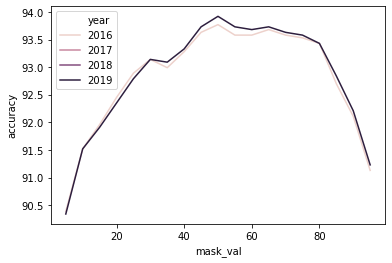

In [14]:
sns.lineplot(data=accuracy_df,x='mask_val',y='accuracy',hue='year')

In [10]:
threshold = 50

##### use the sentinel-urban as a binary mask to erase the incorect pixel in the classification of [2014-2016, 2017-2019]

In [12]:
# fetch the original img

original_maps = []

for year in original_range:
    
    imgs = [ee.Image(f"{img_path}/Spectrum_Normalize_Fourier_Terrain_Meterology_{region_en}_{year}_{seed}") 
            for seed in range(10)]
    
    ten_folds_check = ee.ImageCollection(imgs).sum().gte(4)
    
    original_maps.append(ten_folds_check)


# use the threshold to construct the urban mask
urban_masks = [img.gte(threshold).clip(Region) for img in sentine_urban]

# use the mask to update original img
clasification_update = [original.multiply(mask) for original,mask in zip(original_maps,urban_masks)]
clasification_update[0] = clasification_update[0].multiply(clasification_update[1])

In [13]:
Map = geemap.Map()

Map.add_basemap('HYBRID')

Map.addLayer(original_maps[0],         {'min':0,'max':1},'original_2014_2016')
Map.addLayer(ee.Image(urban_masks[0]), {'min':0,'max':1},'mask_2016')
Map.addLayer(clasification_update[0],  {'min':0,'max':1},'update_2014_2016')

Map.addLayer(original_maps[1],         {'min':0,'max':1},'original_2017_2019')
Map.addLayer(ee.Image(urban_masks[1]), {'min':0,'max':1},'mask_2019')
Map.addLayer(clasification_update[1],  {'min':0,'max':1},'update_2017_2019')

Map.centerObject(Region,10)
Map

Map(center=[30.448045813339593, 118.03734052280193], controls=(WidgetControl(options=['position'], widget=HBox…

##### Export the updated img

In [51]:
# export

for year,img in zip(original_range,clasification_update):
    
    name = f'Sentinel_update_{region_en}_{year}'
    
    # construct a task
    task = ee.batch.Export.image.toAsset(    
                                            image= img,
                                            description=name,
                                            assetId=f'{img_path}/{name}',
                                            region=Region.geometry().bounds(),
                                            scale=30,
                                            maxPixels=int(1e13)
    )

    task.start()

    # print out the process
    print(f'{name} has been exported!')

Sentinel_update_zhongnan_2014_2016 has been exported!
Sentinel_update_zhongnan_2017_2019 has been exported!
